## Traveling Salesman Problem using Quantum Approximate Optimization Algorithm (QAOA)

# Traveling Salesman Problem

The **Traveling Salesman Problem (TSP)** is one of the most famous problems in combinatorial optimization. It can be stated as follows:

> Given a list of cities and the distances between each pair of cities, the goal is to find the **shortest possible route** that visits each city **exactly once** and returns to the starting city.

**Key Points:**

1. **Combinatorial Nature:** For \(n\) cities, there are \((n-1)!\) possible routes (since the starting city can be fixed). This grows factorially, making TSP computationally hard for large \(n\).  

2. **Applications:** TSP is not just theoretical—it appears in logistics, vehicle routing, circuit design, and even DNA sequencing.  

3. **Optimization Goal:** We aim to minimize the **total travel distance** (or cost) of the tour.



Here is a $3$-city examples where we have to decide which direction to travel to minimize the cost. We consider the following distance matrices

$$
\mathbf{D} =
\begin{bmatrix}
0 & 0.9 & 0.8 \\
0.4 & 0 & 0.1 \\
0 & 0.7 & 0
\end{bmatrix}
$$

where the $(i,j)$ entry of the distance matrix indicates the travel distance from city $i$ to city $j$. Notice that the distance matrix does not need to  be symmetrical. Let's visualize the two possible directions.

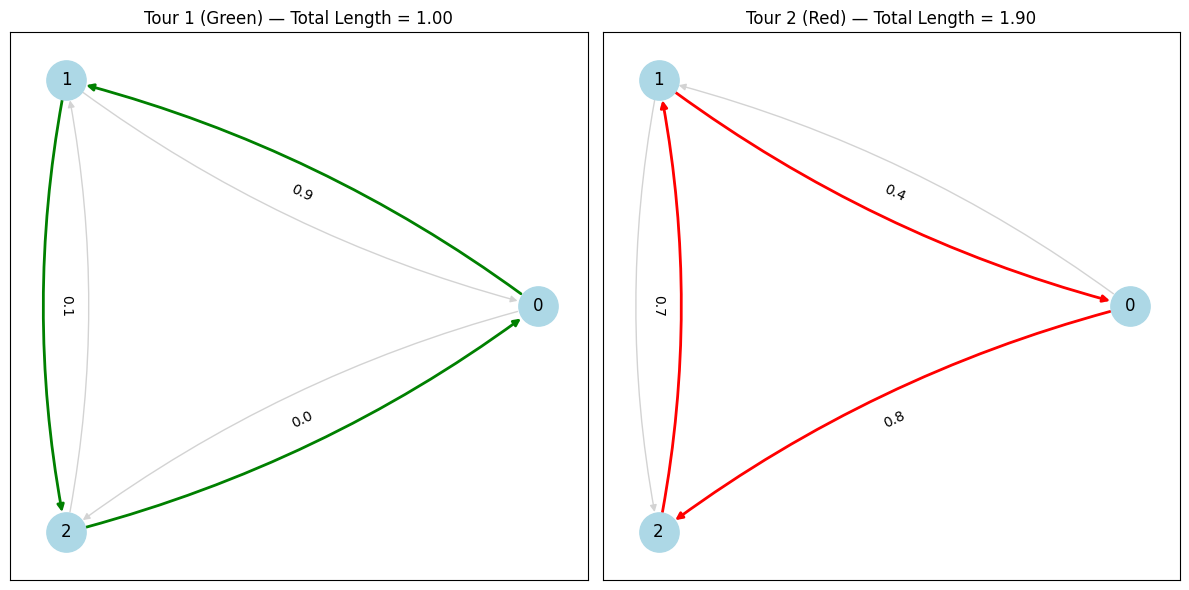

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

dist_matrix = np.array([
    [0, 0.9, 0.8],
    [0.4, 0, 0.1],
    [0, 0.7, 0]
])

# Build directed graph
G = nx.DiGraph()
n = len(dist_matrix)
for i in range(n):
    for j in range(n):
        if dist_matrix[i, j] > 0:
            G.add_edge(i, j, weight=dist_matrix[i, j])

# Two tours
tour1 = [(0, 1), (1, 2), (2, 0)]
tour2 = [(0, 2), (2, 1), (1, 0)]

# Compute total lengths
tour1_length = sum(dist_matrix[i, j] for i, j in tour1)
tour2_length = sum(dist_matrix[i, j] for i, j in tour2)

pos = nx.circular_layout(G)  # nice circular layout

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Tour 1 in green ---
ax = axes[0]
nx.draw_networkx_edges(G, pos, ax=ax, edge_color="lightgray", arrows=True,
                       connectionstyle="arc3,rad=0.1", arrowstyle='-|>', min_source_margin=15, min_target_margin=15)
nx.draw_networkx_edges(G, pos, edgelist=tour1, ax=ax,
                       edge_color="green", width=2, arrows=True,
                       connectionstyle="arc3,rad=0.1", arrowstyle='-|>', min_source_margin=15, min_target_margin=15)
nx.draw_networkx_nodes(G, pos, ax=ax, node_color="lightblue", node_size=800)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=12, font_color="black")
edge_labels = {(i, j): f"{dist_matrix[j, i]:.1f}" for i, j in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_size=10)
ax.set_title(f"Tour 1 (Green) — Total Length = {tour1_length:.2f}")

# --- Tour 2 in red ---
ax = axes[1]
nx.draw_networkx_edges(G, pos, ax=ax, edge_color="lightgray", arrows=True,
                       connectionstyle="arc3,rad=0.1", arrowstyle='-|>', min_source_margin=15, min_target_margin=15)
nx.draw_networkx_edges(G, pos, edgelist=tour2, ax=ax,
                       edge_color="red", width=2, arrows=True,
                       connectionstyle="arc3,rad=0.1", arrowstyle='-|>', min_source_margin=15, min_target_margin=15)
nx.draw_networkx_nodes(G, pos, ax=ax, node_color="lightblue", node_size=800)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=12, font_color="black")
edge_labels = {(i, j): f"{dist_matrix[i, j]:.1f}" for i, j in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_size=10)
ax.set_title(f"Tour 2 (Red) — Total Length = {tour2_length:.2f}")

plt.tight_layout()
plt.show()


We will prefer Tour 1 as the distance is smaller than Tour 2. 

In this tutorial, we will show case a small instance of 3 cities problem and show that we can determine the right direction to travel. This is just a proof of concept of how to formulate TSP in a form that can be attempted using a quantum optimisation algorithm known as Quantum Approximate Optimization Algorithm (QAOA). 

In [4]:
from qiboopt.combinatorial.combinatorial import TSP
import numpy as np
from collections import defaultdict
from qibo import gates
from qibo.models import QAOA
from qibo.result import CircuitResult
from qibo.models.circuit import Circuit


def convert_to_standard_Cauchy(config):
    m = int(np.sqrt(len(config)))
    cauchy = [-1] * m  # Cauchy's notation for permutation, e.g. (1,2,0) or (2,0,1)
    for i in range(m):
        for j in range(m):
            if config[m * i + j] == '1':
                cauchy[j] = i  # citi i is in slot j
    for i in range(m):
        if cauchy[i] == 0:
            cauchy = cauchy[i:] + cauchy[:i]
            return tuple(cauchy)
            # now, the cauchy notation for permutation begins with 0


def evaluate_dist(cauchy):
    '''
    Given a permutation of 0 to n-1, we compute the distance of the tour

    '''
    m = len(cauchy)
    return sum(distance_matrix[cauchy[i]][cauchy[(i+1)%m]] for i in range(m))


def qaoa_function_of_layer(layer, distance_matrix):
    '''
    This is a function to study the impact of the number of layers on QAOA,
    it takes in the number of layers and compute the distance of the mode
    of the histogram obtained from QAOA

    '''
    small_tsp = TSP(distance_matrix)
    obj_hamil, mixer = small_tsp.hamiltonians()
    qaoa = QAOA(obj_hamil, mixer=mixer)
    best_energy, final_parameters, extra = qaoa.minimize(initial_p=[0.1] * layer,
                                         initial_state=initial_state, method='BFGS')
    qaoa.set_parameters(final_parameters)
    quantum_state = qaoa.execute(initial_state)
    circuit = Circuit(9)
    circuit.add(gates.M(*range(9)))
    result = CircuitResult(quantum_state, circuit.measurements,
            small_tsp.backend, nshots=1000)
    freq_counter = result.frequencies()
    # let's combine freq_counter here, first convert each key and sum up the frequency
    cauchy_dict = defaultdict(int)
    for freq_key in freq_counter:
        standard_cauchy_key = convert_to_standard_Cauchy(freq_key)
        cauchy_dict[standard_cauchy_key] += freq_counter[freq_key]
    max_key = max(cauchy_dict, key=cauchy_dict.get)
    print(freq_counter)
    return evaluate_dist(max_key)

np.random.seed(42)
num_cities = 3
distance_matrix = np.array([[0, 0.9, 0.8], [0.4, 0, 0.1],[0, 0.7, 0]])
distance_matrix = distance_matrix.round(1)
small_tsp = TSP(distance_matrix)
initial_parameters = np.random.uniform(0, 1, 2)
initial_state = small_tsp.prepare_initial_state([i for i in range(num_cities)])
qaoa_function_of_layer(2, distance_matrix)

Counter({'100010001': 1000})


np.float64(1.0)

# Reference

1. Robinson, J. (1949). On the Hamiltonian game (a traveling salesman problem) (No. RANDRM303).
2. Farhi, E., Goldstone, J., & Gutmann, S. (2014). A quantum approximate optimization algorithm. arXiv preprint arXiv:1411.4028.
3. Lucas, A. (2014). Ising formulations of many NP problems. Frontiers in physics, 2, 5.
4. Hadfield, S., Wang, Z., O’gorman, B., Rieffel, E. G., Venturelli, D., & Biswas, R. (2019). From the quantum approximate optimization algorithm to a quantum alternating operator ansatz. Algorithms, 12(2), 34.